# Household analysis on OpenSAFELY dummy data

Python code for pulling in the dummy data and running a household regression


In [40]:
# This cell loads the libraries used by the script

%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as op
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# EDA

The next set of cells does exploratory data analysis / plots - we should discuss how to pull this kind of thing out


In [41]:
df = pd.read_csv('./hh_analysis_dataset_DRAFT.csv')

In [42]:
for c in df.columns:
    print(c)

patient_id
age
hh_id
hh_size
case
bmi_measured_date
hba1c_percentage_date
chronic_respiratory_disease_date
chronic_respiratory_disease
chronic_cardiac_disease_date
chronic_cardiac_disease
cancer_date
cancer
perm_immunodef_date
perm_immunodef
temp_immunodef_date
temp_immunodef
other_immuno
chronic_liver_disease_date
chronic_liver_disease
other_neuro_date
other_neuro
stroke_date
stroke
dementia_date
dementia
esrf_date
esrf
hypertension_date
hypertension
ra_sle_psoriasis_date
ra_sle_psoriasis
insulin_date
insulin
statin_date
statin
was_ventilated_flag
sex
rural_urban
region
ethnicity_16
gp_consult_count
bmi
hba1c_mmol_per_mol
hba1c_percentage
asthma_date
asthmacat
ace_inhibitors_date
ace_inhibitors
alpha_blockers_date
alpha_blockers
arbs_date
arbs
betablockers_date
betablockers
calcium_channel_blockers_date
calcium_channel_blockers
combination_bp_meds_date
combination_bp_meds
spironolactone_date
spironolactone
thiazide_diuretics_date
thiazide_diuretics
indexdate
eth5
eth16
stp
imd
agegrou

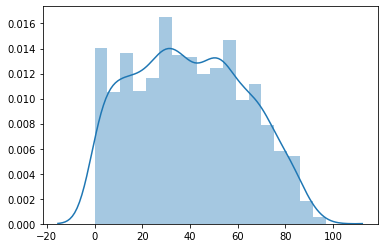

In [43]:
# Visualise the age distribution in the samples

sns.distplot(df.age1.values)

In [31]:
len(df)

2726

In [36]:
hhnums = pd.unique(df.hh_id)
nhh = len(hhids)
print(nhh)

782


In [44]:
# Set up arrays for the size and number positive in each household

hhsizes = np.zeros(nhh)
hhpos = np.zeros(nhh)
hhneg = np.zeros(nhh)
hhmis = np.zeros(nhh)
for i, num in enumerate(hhnums):
    dfh = df[df.hh_id == num]
    hhsizes[i] = len(dfh)
    hhpos[i] = np.sum(dfh.case == 1)
    hhneg[i] = np.sum(dfh.case == 0)
    hhmis[i] = np.sum(pd.isna(dfh.case))

(array([ 50., 201., 222., 116.,  97.,  38.,  42.,   7.,   9.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 9 Patch objects>)

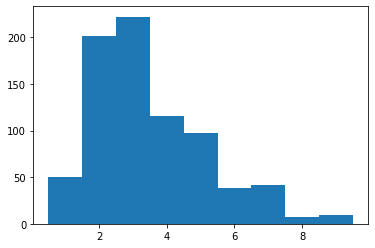

In [49]:
# Check the distribution of household sizes

plt.hist(hhsizes,0.5+np.arange(np.min(hhsizes)-1,np.max(hhsizes)+1))

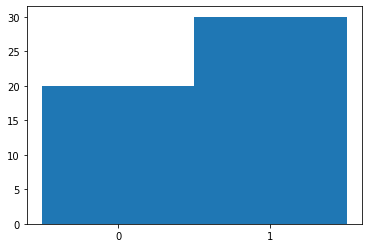

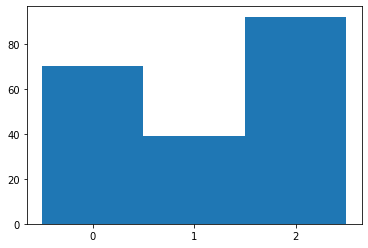

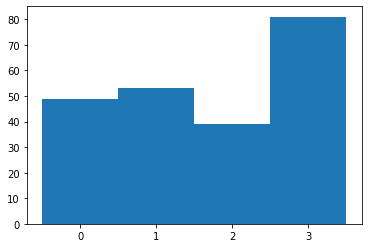

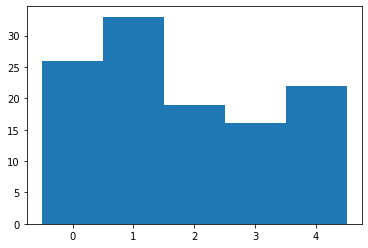

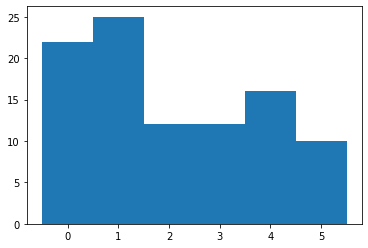

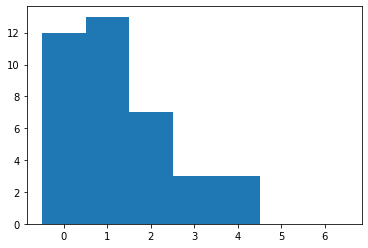

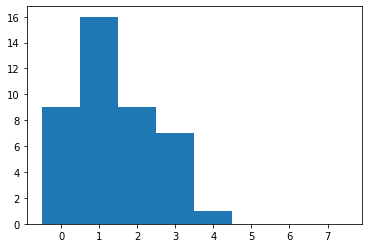

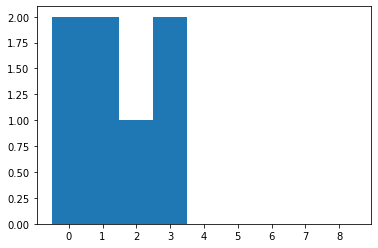

In [53]:
# Look at the distribution of cases in households by size

for nhsize in range(1,9):
    jj = np.where(hhsizes==nhsize)[0]
    plt.figure()
    plt.hist(hhpos[jj],np.arange(-0.5,nhsize+1.5,1.))
    plt.xticks(np.arange(0,nhsize+1,1))

# Data pre-processing

There are two major outputs for each household: a vector y of outcomes and a design matrix X. These are stored in arrays of length equal to the number of households Y and XX respectively.


In [59]:
# This is the number of age classes; here we will follow Roz's interests and consider two young ages

nages = 2

In [60]:
Y = [] # To store outcomes
XX = [] # To store design matrices
for i, num in enumerate(hhnums):
    dfh = df[df.hh_id == num]    
    
    mya = dfh.age1.values
    m = len(mya)
    myx = np.zeros((m,nages))
    myy = np.zeros(m)
    for j, a in enumerate(mya):
        if (a<=9):
            myx[j,:] = np.array([1, 0])
        elif ((a>9) and (a<=18)):
            myx[j,:] = np.array([0, 1])
        if (dfh.case.values[j] == 1):
            myy[j] = 1
    Y.append(myy)
    XX.append(np.atleast_2d(myx))

In [13]:
# The above processes the data - now add final size analysis; first do a run through

In [14]:
def phi(s, logtheta=0.0):
    theta = np.exp(logtheta)
    return ((1.0 + theta*s)**(-1.0/theta))

In [15]:
# Indicative parameters - to be included in a 
llaL = 0.1
llaG = -1.6
logtheta = 1.2
alpha = np.array([0.0])
beta = np.array([0.0])
gamma = np.array([0.0])

In [16]:
nlv = np.zeros(len(hhids)) # Vector of negative log likelihoods
for i in range(0,len(hhids)):
    y = Y[i]
    X = XX[i]
    if np.all(y==0.0):
        nlv[i] = np.exp(llaG)*np.sum(np.exp(alpha@(X.T)))
    else:
        # Sort to go zeros then ones WLOG (could do in pre-processing)
        ii = np.argsort(y)
        y = y[ii]
        X = X[ii,:]
        q = sum(y>0)
        r = 2**q
        m = len(y)
        
        # Quantities that don't vary through the sum
        Bk = np.exp(-np.exp(llaG)*np.exp(alpha@(X.T)))
        laM = np.exp(llaL)*np.outer(np.exp(beta@(X.T)),np.exp(gamma@(X.T)))
        
        BB = np.zeros((r,r)) # To be the Ball matrix
        for jd in range(0,r):
            for omd in range(0,jd+1):
                jstr = format(jd,'0' + str(m) + 'b')
                omstr = format(omd,'0' + str(m) + 'b')
                j = np.array([int(jstr[x]) for x in range(0,len(jstr))])
                om = np.array([int(omstr[x]) for x in range(0,len(omstr))])
                BB[jd,omd] = 1.0/np.prod((phi((1-j)@laM,logtheta)**om)*(Bk**(1-j)))
        nlv[i] = -np.log(LA.solve(BB,np.ones(r))[-1])
nll = np.sum(nlv)
nll

690.2911709403419

In [17]:
# Now try a loop over parameters

In [18]:
def mynll(x):
    
    try: # Ideally catch the linear algebra fail directly
        llaL = x[0]
        llaG = x[1]
        logtheta = x[2]
        alpha = x[3:(3+nages)]
        beta = x[(3+nages):(3+2*nages)]
        gamma = x[(3+2*nages):]

        nlv = np.zeros(len(hhids)) # Vector of negative log likelihoods
        for i in range(0,len(hhids)):
            y = Y[i]
            X = XX[i]
            if np.all(y==0.0):
                nlv[i] = np.exp(llaG)*np.sum(np.exp(alpha@(X.T)))
            else:
                # Sort to go zeros then ones WLOG (could do in pre-processing)
                ii = np.argsort(y)
                y = y[ii]
                X = X[ii,:]
                q = sum(y>0)
                r = 2**q
                m = len(y)

                # Quantities that don't vary through the sum
                Bk = np.exp(-np.exp(llaG)*np.exp(alpha@(X.T)))
                laM = np.exp(llaL)*np.outer(np.exp(beta@(X.T)),np.exp(gamma@(X.T)))

                BB = np.zeros((r,r)) # To be the Ball matrix
                for jd in range(0,r):
                    for omd in range(0,jd+1):
                        jstr = format(jd,'0' + str(m) + 'b')
                        omstr = format(omd,'0' + str(m) + 'b')
                        j = np.array([int(jstr[x]) for x in range(0,len(jstr))])
                        om = np.array([int(omstr[x]) for x in range(0,len(omstr))])
                        BB[jd,omd] = 1.0/np.prod((phi((1-j)@laM,logtheta)**om)*(Bk**(1-j)))
                nlv[i] = -np.log(LA.solve(BB,np.ones(r))[-1])
        nll = np.sum(nlv)
        nll += np.sum(x**2) # Add a Ridge if needed
        return nll
    except:
        nll = np.inf
        return nll

In [19]:
# Indicative parameters - to do, add bounds and mulitple restarts
x0 = np.array([
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
])
mynll(x0)

2895.6535995211

In [35]:
bb = np.array([
    [-10.,0.],
    [-5.,5.],
    [-10.,10.],
    [-5.,5.],
    [-5.,5.],
    [-5.,5.],
])

In [36]:
def callbackF(x, x2=0., x3=0.):
    print('Evaluated at [{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}]: {:.8f}'.format(
        x[0],x[1],x[2],x[3],x[4],x[5],mynll(x)))

In [37]:
# First try from (essentially) the origin 
fout = op.minimize(mynll,x0,method='TNC',callback=callbackF,bounds=bb,options={'maxiter' : 10000})
#xhat = fout.x
fout

Evaluated at [-0.032,-2.945,0.072,-0.508,-0.005,-0.002]: 354.34618701
Evaluated at [-0.327,-3.791,0.731,-0.635,-0.054,-0.021]: 312.74937638
Evaluated at [-1.264,-3.646,1.780,-0.745,-0.192,-0.120]: 300.81025140
Evaluated at [-1.625,-3.702,1.827,-1.043,-0.235,-0.143]: 299.96015004
Evaluated at [-1.761,-3.595,1.088,-0.952,-0.245,-0.145]: 299.52519344
Evaluated at [-1.806,-3.654,0.510,-0.922,-0.264,-0.378]: 299.13706586
Evaluated at [-2.208,-3.713,-0.056,-0.887,-0.420,-0.424]: 298.42150896
Evaluated at [-2.358,-3.705,-0.046,-0.885,-0.488,-0.382]: 298.35121116
Evaluated at [-2.294,-3.699,0.347,-0.916,-0.475,-0.308]: 298.25765181
Evaluated at [-2.300,-3.700,0.290,-0.912,-0.475,-0.320]: 298.25415102
Evaluated at [-2.312,-3.700,0.273,-0.911,-0.474,-0.322]: 298.25368324
Evaluated at [-2.313,-3.700,0.281,-0.911,-0.474,-0.321]: 298.25357954
Evaluated at [-2.318,-3.700,0.291,-0.912,-0.473,-0.318]: 298.25349509
Evaluated at [-2.318,-3.700,0.285,-0.912,-0.473,-0.319]: 298.25345582
Evaluated at [-2.3

     fun: 298.1871741497144
     jac: array([ 0.02378897, -0.02619913, -0.00803198,  0.15986643, -0.02317506,
        0.02890488])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 363
     nit: 58
  status: 1
 success: True
       x: array([-2.33029253, -3.69937915,  0.22444903, -0.92648771, -0.32543164,
       -0.14515716])

In [48]:
# Because box bounded, try multiple restarts with stable algorithm
foutstore = []
np.random.seed(46)
nrestarts = 20
for k in range(0,nrestarts):
    nll0 = np.nan
    while np.isnan(nll0):
        xx0 = np.random.uniform(bb[:,0],bb[:,1])
        nll0 = mynll(xx0)
    try:
        print('Starting at:')
        print(xx0)
        fout = op.minimize(mynll,xx0,
                           bounds=bounds,method='TNC',callback=callbackF,
                           options={'maxiter' : 10000, 'ftol' : 1e-9})
        print('Found:')
        print(fout.x)
        print('')
        foutstore.append(fout)
    except:
        k -= 1

Starting at:
[-2.16167649  1.34833706 -5.01913817  2.58075865 -1.86923064  4.37237357]
Evaluated at [-2.166,-3.289,-5.019,-0.812,-1.869,4.367]: 385.22201944
Evaluated at [-2.841,-4.116,-4.923,-0.876,-1.784,3.498]: 351.90096137
Evaluated at [-2.788,-3.610,-4.861,-0.644,-1.708,1.942]: 331.21595879
Evaluated at [-3.170,-3.703,-4.720,-0.522,-1.557,-0.149]: 325.12969610
Evaluated at [-3.110,-3.704,-4.737,-0.569,-1.571,0.144]: 325.00837835
Evaluated at [-3.160,-3.767,-4.711,-0.606,-1.529,-0.222]: 324.75126338
Evaluated at [-3.109,-3.785,-4.723,-0.673,-1.531,-0.007]: 324.60115232
Evaluated at [-3.085,-3.797,-4.728,-0.714,-1.528,0.084]: 324.58392597
Evaluated at [-3.173,-3.719,-4.708,-0.946,-1.417,-0.280]: 324.10919272
Evaluated at [-3.150,-3.726,-4.712,-1.042,-1.396,-0.193]: 324.03737401
Evaluated at [-3.142,-3.728,-4.714,-1.074,-1.389,-0.164]: 324.03051487
Evaluated at [-3.129,-3.732,-4.716,-1.120,-1.374,-0.116]: 324.02236209


/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


Found:
[-3.12905707 -3.73200935 -4.71633669 -1.12023088 -1.37405034 -0.11558951]

Starting at:
[-9.57134552 -0.59132797  8.2544458  -0.44996081  0.07934341 -4.15092045]
Evaluated at [-9.535,-3.303,8.228,-0.768,0.079,-4.135]: 469.80158026
Evaluated at [-6.079,-4.788,6.336,0.003,2.271,-1.292]: 398.82035298
Evaluated at [0.000,-4.271,5.924,-0.237,1.651,-1.794]: 338.21878846
Evaluated at [0.000,-3.540,4.760,-0.675,0.840,-1.941]: 317.78882632
Evaluated at [0.000,-3.540,4.760,-0.675,0.840,-1.941]: 317.78882632
Evaluated at [0.000,-3.555,2.764,-0.492,0.924,0.071]: 306.39201117
Evaluated at [-0.443,-3.581,2.998,-0.548,0.822,-0.349]: 304.93492518
Evaluated at [-0.702,-3.598,3.117,-0.649,0.754,-0.587]: 304.57702628
Evaluated at [-0.409,-3.586,2.816,-1.013,0.775,-0.235]: 303.72490349
Evaluated at [-0.673,-3.603,2.925,-1.136,0.704,-0.471]: 303.47940493
Evaluated at [-0.627,-3.600,2.898,-1.134,0.713,-0.425]: 303.46808210
Evaluated at [-0.568,-3.597,2.858,-1.115,0.724,-0.364]: 303.45267624
Evaluated

Evaluated at [-4.211,-3.765,-7.433,-1.914,-4.172,-1.544]: 384.30635557
Evaluated at [-1.402,-3.624,-1.775,-0.122,-1.167,-0.438]: 310.56558817
Evaluated at [-2.256,-3.636,-2.330,-0.531,-1.568,-0.547]: 306.94882615
Evaluated at [-2.099,-3.903,-1.078,-0.257,-0.935,-0.285]: 302.67466549
Evaluated at [-2.775,-3.904,-0.754,-0.327,-0.797,-0.218]: 301.77351537
Evaluated at [-2.348,-3.777,-0.955,-0.380,-0.881,-0.260]: 300.88452217
Evaluated at [-2.221,-3.756,-0.414,-1.254,-0.354,-0.108]: 299.07692874
Evaluated at [-2.352,-3.706,-0.462,-1.067,-0.324,0.201]: 298.79142740
Evaluated at [-2.323,-3.721,-0.473,-1.075,-0.357,0.102]: 298.77459038
Evaluated at [-2.323,-3.724,-0.488,-1.055,-0.375,0.083]: 298.77204792
Evaluated at [-2.323,-3.725,-0.498,-1.039,-0.388,0.069]: 298.77100725
Evaluated at [-2.399,-3.692,-0.316,-1.155,-0.258,0.137]: 298.65237364
Evaluated at [-2.489,-3.684,-0.285,-1.034,-0.328,-0.017]: 298.47693953
Evaluated at [-2.520,-3.678,-0.258,-1.015,-0.332,-0.050]: 298.46805475
Evaluated a

Evaluated at [-2.089,-3.660,-2.368,-1.398,-0.242,-0.591]: 305.41021336
Evaluated at [-2.568,-3.626,-2.280,-1.373,-0.240,-0.372]: 304.42966562
Evaluated at [-2.617,-3.742,-2.175,-1.342,-0.256,-0.079]: 303.96466976
Evaluated at [-2.605,-3.741,-2.179,-1.343,-0.256,-0.089]: 303.96404669
Evaluated at [-2.463,-3.688,-2.186,-1.352,-0.254,-0.192]: 303.78737587
Evaluated at [-2.682,-3.602,-2.011,-1.318,-0.259,0.034]: 303.37100385
Evaluated at [-2.686,-3.615,-2.022,-1.319,-0.259,0.033]: 303.36419610
Evaluated at [-2.691,-3.639,-2.034,-1.321,-0.259,0.031]: 303.34673777
Evaluated at [-2.387,-3.525,-1.300,-1.268,-0.261,0.060]: 301.34291973
Evaluated at [-1.865,-3.678,-0.045,-1.190,-0.264,0.083]: 299.44734963
Evaluated at [-2.000,-3.672,-0.370,-1.211,-0.263,0.075]: 299.35255687
Evaluated at [-2.000,-3.722,-0.267,-1.207,-0.263,0.074]: 299.27249451
Evaluated at [-2.021,-3.722,-0.315,-1.210,-0.263,0.073]: 299.26972436
Evaluated at [-2.141,-3.682,-0.450,-1.223,-0.262,0.067]: 299.09778344
Evaluated at [-

/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars


Evaluated at [-1.606,-3.705,2.208,-0.873,0.311,-0.152]: 300.86155849
Evaluated at [-1.643,-3.687,2.004,-1.175,-0.382,-0.099]: 300.35060641
Evaluated at [-1.527,-3.691,1.687,-0.943,-0.367,-0.076]: 299.93740071
Evaluated at [-1.525,-3.689,1.675,-0.943,-0.381,-0.180]: 299.92525226
Evaluated at [-1.527,-3.679,1.597,-0.951,-0.472,-0.173]: 299.90448915
Evaluated at [-1.843,-3.645,1.010,-0.967,-0.874,0.142]: 299.49950238
Evaluated at [-1.886,-3.730,1.007,-0.969,-0.842,0.123]: 299.32089278
Evaluated at [-1.937,-3.658,1.003,-0.958,-0.800,0.099]: 299.19542660
Evaluated at [-1.967,-3.721,1.000,-0.960,-0.772,0.083]: 299.08528929
Evaluated at [-2.160,-3.715,0.723,-0.963,-0.917,-0.224]: 298.85186512
Evaluated at [-2.271,-3.771,0.427,-0.963,-0.786,-0.155]: 298.67956654
Evaluated at [-2.270,-3.703,0.426,-0.956,-0.769,-0.155]: 298.48001424
Found:
[-2.27047458 -3.70287649  0.4260212  -0.9562966  -0.76853653 -0.15491375]

Starting at:
[-9.41948684  2.55665434 -8.70794244 -2.44266576 -3.30392236 -3.048727

Evaluated at [-2.435,-3.669,0.065,-0.919,-0.238,-0.168]: 298.26478974
Evaluated at [-2.414,-3.667,0.090,-0.939,-0.231,-0.220]: 298.25665955
Evaluated at [-2.410,-3.667,0.116,-0.944,-0.233,-0.248]: 298.25491352
Evaluated at [-2.409,-3.668,0.126,-0.946,-0.233,-0.259]: 298.25477301
Evaluated at [-2.412,-3.668,0.105,-0.943,-0.232,-0.228]: 298.25271584
Evaluated at [-2.418,-3.675,0.112,-0.958,-0.228,-0.104]: 298.23544194
Evaluated at [-2.404,-3.680,0.238,-0.989,-0.235,-0.169]: 298.21689891
Evaluated at [-2.406,-3.681,0.232,-0.990,-0.234,-0.142]: 298.21618846
Evaluated at [-2.387,-3.687,0.186,-0.991,-0.228,-0.099]: 298.20951100
Evaluated at [-2.359,-3.692,0.153,-0.990,-0.224,-0.134]: 298.20424859
Evaluated at [-2.356,-3.690,0.163,-0.989,-0.226,-0.173]: 298.20258853
Evaluated at [-2.363,-3.689,0.173,-0.989,-0.227,-0.166]: 298.20228472
Evaluated at [-2.363,-3.689,0.172,-0.989,-0.227,-0.167]: 298.20227953
Evaluated at [-2.363,-3.689,0.172,-0.989,-0.227,-0.167]: 298.20227925
Evaluated at [-2.362

Evaluated at [-7.667,-3.817,1.573,-1.123,0.765,-1.888]: 353.91624417
Evaluated at [-6.708,-3.309,1.560,-1.012,0.668,-1.651]: 343.95975356
Evaluated at [-4.129,-3.566,1.579,0.205,1.408,-1.971]: 322.30503572
Evaluated at [-2.076,-3.779,1.450,-0.670,1.289,-2.035]: 306.62595245
Evaluated at [-2.525,-3.716,1.402,-1.172,0.218,-1.883]: 303.35169776
Evaluated at [-2.646,-3.698,1.387,-0.903,-0.154,-1.804]: 302.95252067
Evaluated at [-2.468,-3.715,1.388,-0.790,0.129,-1.804]: 302.77269562
Evaluated at [-2.484,-3.689,1.334,-0.683,-0.400,-1.594]: 302.03438252
Evaluated at [-2.404,-3.682,1.302,-0.564,-0.566,-1.472]: 301.85364082
Evaluated at [-2.318,-3.688,1.297,-0.497,-0.476,-1.450]: 301.79969072
Evaluated at [-2.263,-3.692,1.293,-0.463,-0.286,-1.429]: 301.74871746
Evaluated at [-2.377,-3.684,1.300,-0.560,-0.279,-1.452]: 301.64924428
Evaluated at [-2.425,-3.681,1.302,-0.616,-0.107,-1.452]: 301.61400761
Evaluated at [-2.385,-3.683,1.300,-0.583,-0.182,-1.448]: 301.59440920
Evaluated at [-2.362,-3.684

Evaluated at [-7.676,-3.660,3.090,-4.385,-3.989,1.961]: 400.08010313
Evaluated at [-5.364,-4.384,2.512,-4.127,-3.332,0.285]: 370.22619485
Evaluated at [-2.011,-4.460,1.566,-3.952,-2.447,-1.963]: 344.38191548
Evaluated at [-1.815,-3.756,1.377,-4.092,-2.448,-2.035]: 328.53402688
Evaluated at [-1.868,-3.650,1.356,-4.117,-2.463,-1.985]: 328.14083861
Evaluated at [-1.904,-3.450,0.360,-4.150,-2.149,-1.402]: 325.25406896
Evaluated at [-1.783,-3.610,-0.647,-4.097,-1.739,-0.926]: 322.04935513
Evaluated at [-1.818,-3.686,-1.008,-4.073,-1.561,-0.732]: 321.62421934
Evaluated at [-2.555,-3.705,-0.713,-4.050,-1.277,-0.462]: 319.36537231
Evaluated at [-2.599,-3.685,-0.593,-4.055,-1.301,-0.483]: 319.34262748
Evaluated at [-2.504,-3.712,-0.754,-4.047,-1.255,-0.407]: 319.24336041
Evaluated at [-2.172,-3.668,-0.422,-4.041,-1.130,0.138]: 318.14572560
Evaluated at [-2.221,-3.619,-0.106,-4.050,-1.162,0.168]: 318.00327860
Evaluated at [-2.212,-3.629,-0.169,-4.048,-1.154,0.160]: 317.99530254
Evaluated at [-2.

Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18464016
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18464013
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18464013
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18463968
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18463968
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18463968
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18463966
Evaluated at [-2.333,-3.697,0.228,-0.953,-0.314,-0.157]: 298.18463966
Found:
[-2.33324124 -3.69709364  0.22794524 -0.95317402 -0.31394625 -0.15689523]

Starting at:
[-2.76500831 -4.76809292 -7.54119857 -0.51162417 -1.81107538 -0.13573736]
Evaluated at [-2.699,-3.577,-7.236,-0.469,-1.714,-0.135]: 355.26146816
Evaluated at [-1.105,-3.947,1.077,-3.054,0.893,-0.123]: 316.51351951
Evaluated at [-2.379,-3.731,2.365,-2.242,0.333,-0.192]: 306.58448982
Evaluated at [-2.556,-3.508,1.026,-0.920,-0.129,-0.194]: 300.2

Evaluated at [-2.306,-3.726,0.172,-0.959,-0.330,-0.571]: 298.40730017
Evaluated at [-2.333,-3.726,0.195,-0.959,-0.330,-0.567]: 298.40195790
Evaluated at [-2.342,-3.726,0.202,-0.959,-0.330,-0.565]: 298.40164205
Evaluated at [-2.231,-3.726,0.235,-0.917,-0.330,-0.485]: 298.35550722
Evaluated at [-2.294,-3.726,0.428,-0.869,-0.330,-0.370]: 298.30500113
Evaluated at [-2.276,-3.725,0.403,-0.873,-0.330,-0.380]: 298.30294220
Evaluated at [-2.276,-3.725,0.402,-0.873,-0.330,-0.380]: 298.30293943
Evaluated at [-2.311,-3.725,0.401,-0.871,-0.330,-0.372]: 298.29824728
Evaluated at [-2.350,-3.725,0.263,-0.883,-0.330,-0.398]: 298.28717410
Evaluated at [-2.338,-3.725,0.292,-0.881,-0.330,-0.393]: 298.28642730
Evaluated at [-2.330,-3.725,0.296,-0.881,-0.330,-0.394]: 298.28614493
Evaluated at [-2.328,-3.725,0.297,-0.881,-0.330,-0.394]: 298.28612563
Evaluated at [-2.301,-3.725,0.271,-0.881,-0.330,-0.388]: 298.28092467
Evaluated at [-2.315,-3.725,0.174,-0.880,-0.330,-0.369]: 298.27213384
Evaluated at [-2.328

In [49]:
ff = np.inf*np.ones(nrestarts)
for i in range(0,nrestarts):
    ff[i] = foutstore[i].fun

In [55]:
xhat = foutstore[ff.argmin()].x

In [58]:
pn = len(x0)
delta = 1e-6
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in tqdm(range(0,pn)):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = mynll(xhat+ej+ek) - mynll(xhat+ej-ek) - mynll(xhat-ej+ek) + mynll(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - mynll(xhat+2*ej) + 16*mynll(xhat+ej) - 30*mynll(xhat) + 16*mynll(xhat-ej) - mynll(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2)) # TO DO: replace with a chol ...
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
stds

array([0.40139076, 0.12684037, 0.46975444, 0.39957968, 0.44421121,
       0.31414918])

In [60]:
print('Baseline probability of infection from outside is {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*(1.-np.exp(-np.exp(xhat[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]-1.96*stds[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]+1.96*stds[1]))),
    ))

# phi gets bigger as xhat[1] gets smaller and bigger as xhat[2] gets bigger
# 'Safest' method is Monte Carlo - sample 
mymu = xhat[[0,2]]
mySig = covmat[[0,2],:][:,[0,2]]
m = 4000
sarvec = np.zeros(m)
for i in range(0,m):
    uu = np.random.multivariate_normal(mymu,mySig)
    sarvec[i] = 100.*(1.-phi(np.exp(uu[0]),uu[1]))
    
print('Baseline SAR is {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*(1.-phi(np.exp(xhat[0]),xhat[2])),
    np.percentile(sarvec,2.5),
    np.percentile(sarvec,97.5),
    ))

print('Relative external exposure for <=20yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[3]),
    100.*np.exp(xhat[3]-1.96*stds[3]),
    100.*np.exp(xhat[3]+1.96*stds[3]),
    ))
print('Relative susceptibility for <=20yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[4]),
    100.*np.exp(xhat[4]-1.96*stds[4]),
    100.*np.exp(xhat[4]+1.96*stds[4]),
    ))
print('Relative transmissibility for <=20yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[5]),
    100.*np.exp(xhat[5]-1.96*stds[5]),
    100.*np.exp(xhat[5]+1.96*stds[5]),
    ))

Baseline probability of infection from outside is 2.4 (1.9,3.1) %
Baseline SAR is 8.7 (4.3,17.2) %
Relative external exposure for <=20yo 38.6 (17.6,84.4) %
Relative susceptibility for <=20yo 73.1 (30.6,174.5) %
Relative transmissibility for <=20yo 85.5 (46.2,158.2) %
